In [4]:
# imports, parameters, environment, etc.
import torch
import torch.nn as nn
from utilities.ogbench_utilities import *
from diffusion_planner import DiffusionPlannerConfig
from diffusion_planner import eval_model as diffusion_planer_eval
from utilities.cleandiffuser.invdynamic import MlpInvDynamic
from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
from utilities.cleandiffuser.nn_diffusion import JannerUNet1d,CNN1dShiftEq,ConvNext1dShiftEq
from utilities.cleandiffuser.nn_condition import MLPCondition
from utilities.gridland_environment import *
from utilities.toy_env_utilities import ToyEnvInvDyn
import matplotlib.pyplot as plt
from matplotlib import colormaps
env = 'gridland'
n_size = 5
memory = 1
horizon = 512 # for generation so must be power of 2
num_envs = 100
num_samples = 1
num_episodes = 1 # try not to change this i haven't validated it works and suspect heavily that it does not 
temperature = 0.5
n_exec_steps = 25
render = True
visualize = False
# gets the set of trajectories from the training data 
import numpy as np 
from utilities.gridland_environment import *
from utilities.ogbench_utilities import GCSequenceDataset
config = DiffusionPlannerConfig()
config.horizon = 500
config.gen_horizon = 512
config.goal_sample_gamma = 0.99
config.allow_partial_subsamples = False
config.goal_padding = False
envs, dataset, _ = make_envs_and_datasets_gridland(n_size=5,num_envs = config.num_envs)
env = GridLand(n_size=5,timeout = 500)
env.reset()
train_dataset = GCSequenceDataset(dataset, config) # new sequence dataset
batch = train_dataset.sample(idxs=range(50))
#batch = train_dataset.sample()
print(batch['observations'].shape)
traj_visitations = []
for trajectory in batch['observations']:
    visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
    traj_visitations.append(visited_intersections_idx)
    #print(trajectory)
training_trajectory_visitations = get_trajectory_sets(traj_visitations)
print('# of Unique Training Trajectories:',len(training_trajectory_visitations))
print('Total # of Env:',num_envs*num_samples)

Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 348432.42it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 100


In [3]:
### eval for base unconditional u-net
# loads config, modifies to work w/given parameters
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = False
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True
config.open_loop_invdyn = False
config.guidance = 'none'
config.goal_sample_dist = 'end'
config.use_shift_equivariant_arch = False


# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
if config.use_shift_equivariant_arch:
        #nn_diffusion = ConvNext1dShiftEq(obs_dim)
        nn_diffusion = CNN1dShiftEq(obs_dim,kernel_expansion_rate=8)
else:
        nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)

# creates classifier network if needed
if 'classifier' in config.guidance:
        nn_classifier = HalfJannerUNet1d(
        config.gen_horizon, obs_dim + act_dim, out_dim=1,
        model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
        timestep_emb_type="positional", kernel_size=3)
        classifier = CumRewClassifier(nn_classifier, device=config.device)
else:
        classifier = None
# creates condition network if needed (when using classifier-free guidance)
if 'cfg' in config.guidance:
        nn_condition = MLPCondition(
        in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
else:
        nn_condition = None
# ----------------- Masking ------------------- # some changes to remove gen. over actions
# fix_mask that tells Diffusion model what parts of sequence to ignore during training
# and which parts to inpaint with a prior during sampling. We'll only mask the first
# state now (which should never be getting predicted from random)
# but all others we keep during training, and then modify later during sampling.
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

# --------------- Inverse Dynamics --------------------
if not config.toy_env:
        invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
        invdyn.load(config.invdyn_path)
        invdyn.eval()
else:
        invdyn = ToyEnvInvDyn()
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
#agent.load('trained_models/DiffusionPlanner-CFG-Test-gridland-n5-gc-6fdd634cdiffusion_ckpt_latest.pt') # u-net model
#agent.load('trained_models/DP-EqNet-Uncond-FullSeq-UncondEnv-500k-gridland-n5-d0353311diffusion_ckpt_latest.pt')
# rate = 3 model with some changes
#agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-250k-gridland-n5-4fbf3c4ddiffusion_ckpt_400000.pt')
#agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-250k-gridland-n5-4fbf3c4ddiffusion_ckpt_400000.pt')
#agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-kexp5-gridland-n5-83f69536diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-kexp8-gridland-n5-7176bd03diffusion_ckpt_latest.pt')

agent.load('paper_models/DP-UNet-gridland-n5-37166c54diffusion_ckpt_latest.pt')
#agent.load('paper_models/DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_latest.pt')

# Environment info 
print('==== Unconditional: U-Net Default ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
avg_completion = 0
trajectories = []
for i in range(num_samples):
        envs.reset()
        avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
        # pads trajectory samples to 512
        new_trajectory_samples = []
        for traj in trajectories_sample:
                new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                #print(new_traj.shape)
                new_trajectory_samples.append(new_traj)
        avg_completion += avg_completion_sample
        trajectories += new_trajectory_samples
avg_completion = avg_completion / num_samples
#print(trajectories[0].shape)
print('Avg. Completion:',avg_completion)
if visualize:
        env = GridLand(n_size=n_size,timeout = 500)
        env.reset()
        fig, ax = env.get_mpl_plot()
        #print('replans',np.array(replans).shape)
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
        if num_envs == 1:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
        else:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
        #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


        if num_envs == 1:
                replan_colors = colormaps['plasma_r']
                gradient = np.linspace(0, 1, len(replans[0]))
                for i,replan in enumerate(replans[0]):
                        #print(replan.shape)
                        ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

        #print(trajectories[0].shape)
                visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
        #print(visited_intersections.shape)
                ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
        ax.legend()
traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
print(len(filtered_trajectories))
print('# of Unique Generated Trajectories:',len(filtered_trajectories))
print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations

/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

==== Unconditional: U-Net Default ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:12<00:00, 12.37s/it]


Avg. Completion: 1.0
35
# of Unique Generated Trajectories: 35
# of New Generated Trajectories: 0
% of Generated Trajectories Novel: 0.0


In [5]:
### eval for base unconditional u-net with aug
# loads config, modifies to work w/given parameters
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = False
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True
config.open_loop_invdyn = False
config.guidance = 'none'
config.goal_sample_dist = 'end'
config.use_shift_equivariant_arch = False

visualize = False
# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
if config.use_shift_equivariant_arch:
        #nn_diffusion = ConvNext1dShiftEq(obs_dim)
        nn_diffusion = CNN1dShiftEq(obs_dim,kernel_expansion_rate=8)
else:
        nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
        use_timestep_emb=config.use_timestep_embeddings)

# creates classifier network if needed
if 'classifier' in config.guidance:
        nn_classifier = HalfJannerUNet1d(
        config.gen_horizon, obs_dim + act_dim, out_dim=1,
        model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
        timestep_emb_type="positional", kernel_size=3)
        classifier = CumRewClassifier(nn_classifier, device=config.device)
else:
        classifier = None
# creates condition network if needed (when using classifier-free guidance)
if 'cfg' in config.guidance:
        nn_condition = MLPCondition(
        in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
else:
        nn_condition = None
# ----------------- Masking ------------------- # some changes to remove gen. over actions
# fix_mask that tells Diffusion model what parts of sequence to ignore during training
# and which parts to inpaint with a prior during sampling. We'll only mask the first
# state now (which should never be getting predicted from random)
# but all others we keep during training, and then modify later during sampling.
fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.gen_horizon, obs_dim))

# --------------- Diffusion Model --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion = nn_diffusion, 
        nn_condition = nn_condition,
        classifier = classifier, 
        fix_mask=fix_mask, 
        loss_weight=loss_weight, 
        ema_rate=config.ema_rate,
        device=config.device,
        diffusion_steps=config.diffusion_steps, 
        predict_noise=config.predict_noise)

# --------------- Inverse Dynamics --------------------
if not config.toy_env:
        invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
        invdyn.load(config.invdyn_path)
        invdyn.eval()
else:
        invdyn = ToyEnvInvDyn()
#agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
#agent.load('trained_models/DiffusionPlanner-CFG-Test-gridland-n5-gc-6fdd634cdiffusion_ckpt_latest.pt') # u-net model
#agent.load('trained_models/DP-EqNet-Uncond-FullSeq-UncondEnv-500k-gridland-n5-d0353311diffusion_ckpt_latest.pt')
# rate = 3 model with some changes
#agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-250k-gridland-n5-4fbf3c4ddiffusion_ckpt_400000.pt')
#agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-250k-gridland-n5-4fbf3c4ddiffusion_ckpt_400000.pt')
#agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-kexp5-gridland-n5-83f69536diffusion_ckpt_latest.pt')
#agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-kexp8-gridland-n5-7176bd03diffusion_ckpt_latest.pt')

#agent.load('paper_models/DP-UNet-gridland-n5-37166c54diffusion_ckpt_latest.pt')
agent.load('paper_models/DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_latest.pt')

# Environment info 
print('==== Unconditional: U-Net Augmentation ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
avg_completion = 0
trajectories = []
for i in range(num_samples):
        envs.reset()
        avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
        # pads trajectory samples to 512
        new_trajectory_samples = []
        for traj in trajectories_sample:
                new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                #print(new_traj.shape)
                new_trajectory_samples.append(new_traj)
        avg_completion += avg_completion_sample
        trajectories += new_trajectory_samples
avg_completion = avg_completion / num_samples
print('Avg. Completion:',avg_completion)
if visualize:
        env = GridLand(n_size=n_size,timeout = 500)
        env.reset()
        fig, ax = env.get_mpl_plot()
        #print('replans',np.array(replans).shape)
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
        if num_envs == 1:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
        else:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
        #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


        if num_envs == 1:
                replan_colors = colormaps['plasma_r']
                gradient = np.linspace(0, 1, len(replans[0]))
                for i,replan in enumerate(replans[0]):
                        #print(replan.shape)
                        ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

        #print(trajectories[0].shape)
                visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
        #print(visited_intersections.shape)
                ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
        ax.legend()
traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
print(len(filtered_trajectories))
print('# of Unique Generated Trajectories:',len(filtered_trajectories))
print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations

==== Unconditional: U-Net Augmentation ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [02:11<00:00, 131.19s/it]


Avg. Completion: 0.99
78
# of Unique Generated Trajectories: 78
# of New Generated Trajectories: 55
% of Generated Trajectories Novel: 0.7051282051282052


In [4]:
### eval for position equivaraint model w/pos enc
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = False
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True
config.open_loop_invdyn = False
config.use_shift_equivariant_arch = True
config.add_positional_encoding = True

# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

# loads inverse dynamics
invdyn = ToyEnvInvDyn()
#invdyn.load(config.invdyn_path)

# loads agent 
# --------------- Network Architecture -----------------# 
#nn_diffusion = JannerUNet1dShiftEq(obs_dim)
#nn_diffusion = ConvNext1dShiftEq(obs_dim)
nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position=config.add_positional_encoding)


# ----------------- Masking -------------------
# NOTE - not sure what any of this does (should figure out!)
fix_mask = torch.zeros((config.horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.horizon, obs_dim))

# --------------- difuse --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion, None,
        fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
        device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)


#agent.load('paper_models/DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_latest.pt')

agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')

# Environment info 
print('==== Unconditional EqNet w/PosEnc ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
avg_completion = 0
trajectories = []
for i in range(num_samples):
        envs.reset()
        avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
        # pads trajectory samples to 512
        new_trajectory_samples = []
        for traj in trajectories_sample:
                new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                #print(new_traj.shape)
                new_trajectory_samples.append(new_traj)
        avg_completion += avg_completion_sample
        trajectories += new_trajectory_samples
avg_completion = avg_completion / num_samples
print('Avg. Completion:',avg_completion)

if visualize:
        env = GridLand(n_size=n_size,timeout = 500)
        env.reset()
        fig, ax = env.get_mpl_plot()
        #print('replans',np.array(replans).shape)
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
        if num_envs == 1:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
        else:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
        #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


        if num_envs == 1:
                if n_exec_steps != horizon:
                        replan_colors = colormaps['plasma_r']
                        gradient = np.linspace(0, 1, len(replans[0]))
                        for i,replan in enumerate(replans[0]):
                                #print(replan.shape)
                                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)
                else:
                        replan_colors = colormaps['plasma_r']
                        gradient = np.linspace(0, 1, len(replans[0]))
                        thingy = ax.scatter(replans[0][0][:,0],replans[0][0][:,1],c=range(len(replans[0][0][:,0])),s=5,label='Plan' + str(i),zorder=10-i)
                        fig.colorbar(thingy)


        #print(trajectories[0].shape)
                visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
        #print(visited_intersections.shape)
                ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
        ax.legend()
traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
print(len(filtered_trajectories))
print('# of Unique Generated Trajectories:',len(filtered_trajectories))
print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations


==== Unconditional EqNet w/PosEnc ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:24<00:00, 24.08s/it]


Avg. Completion: 0.99265625
99
# of Unique Generated Trajectories: 99
# of New Generated Trajectories: 57
% of Generated Trajectories Novel: 0.5757575757575758


In [5]:
### eval for position equivaraint model normal
config = DiffusionPlannerConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = False
config.gridland = True
config.n_size = n_size
config.pad = False
config.gen_horizon = horizon
config.toy_env = True
config.open_loop_invdyn = False
config.use_shift_equivariant_arch = True
config.add_positional_encoding = False

# loads environment
envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

# loads inverse dynamics
invdyn = ToyEnvInvDyn()
#invdyn.load(config.invdyn_path)

# loads agent 
# --------------- Network Architecture -----------------# 
#nn_diffusion = JannerUNet1dShiftEq(obs_dim)
#nn_diffusion = ConvNext1dShiftEq(obs_dim)
nn_diffusion = CNN1dShiftEq(obs_dim,
                                    kernel_expansion_rate=config.kernel_expansion_rate,
                                    model_dim = config.model_dim,
                                    emb_dim = config.emb_dim,
                                    encode_position=config.add_positional_encoding)


# ----------------- Masking -------------------
# NOTE - not sure what any of this does (should figure out!)
fix_mask = torch.zeros((config.horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.horizon, obs_dim))

# --------------- difuse --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion, None,
        fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
        device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)


agent.load('paper_models/DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_latest.pt')

#agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')

# Environment info 
print('==== Unconditional EqNet Normal ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
avg_completion = 0
trajectories = []
for i in range(num_samples):
        envs.reset()
        avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
        # pads trajectory samples to 512
        new_trajectory_samples = []
        for traj in trajectories_sample:
                new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                #print(new_traj.shape)
                new_trajectory_samples.append(new_traj)
        avg_completion += avg_completion_sample
        trajectories += new_trajectory_samples
avg_completion = avg_completion / num_samples
print('Avg. Completion:',avg_completion)

if visualize:
        env = GridLand(n_size=n_size,timeout = 500)
        env.reset()
        fig, ax = env.get_mpl_plot()
        #print('replans',np.array(replans).shape)
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
        if num_envs == 1:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
        else:
                ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
        #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
        #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


        if num_envs == 1:
                if n_exec_steps != horizon:
                        replan_colors = colormaps['plasma_r']
                        gradient = np.linspace(0, 1, len(replans[0]))
                        for i,replan in enumerate(replans[0]):
                                #print(replan.shape)
                                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)
                else:
                        replan_colors = colormaps['plasma_r']
                        gradient = np.linspace(0, 1, len(replans[0]))
                        thingy = ax.scatter(replans[0][0][:,0],replans[0][0][:,1],c=range(len(replans[0][0][:,0])),s=5,label='Plan' + str(i),zorder=10-i)
                        fig.colorbar(thingy)


        #print(trajectories[0].shape)
                visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
        #print(visited_intersections.shape)
                ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
        ax.legend()
traj_visitations = []
trajectories = np.array(trajectories)
trajectories = np.transpose(trajectories,(0,2,1,3))
#print(trajectories.shape)
for ep in trajectories:
        for trajectory in ep:
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
print(len(filtered_trajectories))
print('# of Unique Generated Trajectories:',len(filtered_trajectories))
print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
#training_trajectory_visitations


==== Unconditional EqNet Normal ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


  0%|          | 0/1 [00:09<?, ?it/s]

KeyboardInterrupt



## big crazy replanning vs arch experiment thingy can delete later

In [1]:
# imports, parameters, environment, etc.
for meow in range(5):
        print('trial',meow)
        import torch
        import torch.nn as nn
        from utilities.ogbench_utilities import *
        from diffusion_planner import DiffusionPlannerConfig
        from diffusion_planner import eval_model as diffusion_planer_eval
        from utilities.cleandiffuser.invdynamic import MlpInvDynamic
        from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
        from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
        from utilities.cleandiffuser.nn_diffusion import JannerUNet1d,CNN1dShiftEq,ConvNext1dShiftEq
        from utilities.cleandiffuser.nn_condition import MLPCondition
        from utilities.gridland_environment import *
        from utilities.toy_env_utilities import ToyEnvInvDyn
        import matplotlib.pyplot as plt
        from matplotlib import colormaps
        env = 'gridland'
        n_size = 5
        memory = 1
        horizon = 512 # for generation so must be power of 2
        num_envs = 100
        num_samples = 8
        num_episodes = 1 # try not to change this i haven't validated it works and suspect heavily that it does not 
        temperature = 0.5
        n_exec_steps = 25
        render = True
        visualize = False
        # gets the set of trajectories from the training data 
        import numpy as np 
        from utilities.gridland_environment import *
        from utilities.ogbench_utilities import GCSequenceDataset
        config = DiffusionPlannerConfig()
        config.horizon = 500
        config.gen_horizon = 512
        config.goal_sample_gamma = 0.99
        config.allow_partial_subsamples = False
        config.goal_padding = False
        envs, dataset, _ = make_envs_and_datasets_gridland(n_size=5,num_envs = config.num_envs)
        env = GridLand(n_size=5,timeout = 500)
        env.reset()
        train_dataset = GCSequenceDataset(dataset, config) # new sequence dataset
        batch = train_dataset.sample(idxs=range(50))
        #batch = train_dataset.sample()
        print(batch['observations'].shape)
        traj_visitations = []
        for trajectory in batch['observations']:
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
        #print(trajectory)
        training_trajectory_visitations = get_trajectory_sets(traj_visitations)
        print('# of Unique Training Trajectories:',len(training_trajectory_visitations))
        print('Total # of Env:',num_envs*num_samples)

        ### eval for base unconditional u-net with aug
        # loads config, modifies to work w/given parameters
        config = DiffusionPlannerConfig()
        config.memory = memory
        config.horizon = horizon
        config.num_envs = num_envs
        config.num_episodes = num_episodes
        config.n_exec_steps = n_exec_steps
        config.env = env
        config.inpaint = False
        config.gridland = True
        config.n_size = n_size
        config.pad = False
        config.gen_horizon = horizon
        config.toy_env = True
        config.open_loop_invdyn = False
        config.guidance = 'none'
        config.goal_sample_dist = 'end'
        config.use_shift_equivariant_arch = False

        visualize = False
        # loads environment
        envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
        obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]
        if config.use_shift_equivariant_arch:
                #nn_diffusion = ConvNext1dShiftEq(obs_dim)
                nn_diffusion = CNN1dShiftEq(obs_dim,kernel_expansion_rate=8)
        else:
                nn_diffusion = JannerUNet1d(
                obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
                timestep_emb_type="positional", attention=config.self_attention, kernel_size=5,
                use_timestep_emb=config.use_timestep_embeddings)

        # creates classifier network if needed
        if 'classifier' in config.guidance:
                nn_classifier = HalfJannerUNet1d(
                config.gen_horizon, obs_dim + act_dim, out_dim=1,
                model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=config.task.dim_mult,
                timestep_emb_type="positional", kernel_size=3)
                classifier = CumRewClassifier(nn_classifier, device=config.device)
        else:
                classifier = None
        # creates condition network if needed (when using classifier-free guidance)
        if 'cfg' in config.guidance:
                nn_condition = MLPCondition(
                in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)
        else:
                nn_condition = None
        # ----------------- Masking ------------------- # some changes to remove gen. over actions
        # fix_mask that tells Diffusion model what parts of sequence to ignore during training
        # and which parts to inpaint with a prior during sampling. We'll only mask the first
        # state now (which should never be getting predicted from random)
        # but all others we keep during training, and then modify later during sampling.
        fix_mask = torch.zeros((config.gen_horizon, obs_dim)) 
        fix_mask[0, :] = 1. # for the starting/current state
        loss_weight = torch.ones((config.gen_horizon, obs_dim))

        # --------------- Diffusion Model --------------------
        agent = DiscreteDiffusionSDE(
                nn_diffusion = nn_diffusion, 
                nn_condition = nn_condition,
                classifier = classifier, 
                fix_mask=fix_mask, 
                loss_weight=loss_weight, 
                ema_rate=config.ema_rate,
                device=config.device,
                diffusion_steps=config.diffusion_steps, 
                predict_noise=config.predict_noise)

        # --------------- Inverse Dynamics --------------------
        if not config.toy_env:
                invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
                invdyn.load(config.invdyn_path)
                invdyn.eval()
        else:
                invdyn = ToyEnvInvDyn()
        #agent.load('trained_models/DP-EqNet-Uncond-gridland-n5-gc-4654c546diffusion_ckpt_latest.pt')
        #agent.load('trained_models/DP-EqNet-Uncond-Subseq-CondEnv-500k-gridland-n5-gc-988954fbdiffusion_ckpt_latest.pt')
        #agent.load('trained_models/DiffusionPlanner-CFG-Test-gridland-n5-gc-6fdd634cdiffusion_ckpt_latest.pt') # u-net model
        #agent.load('trained_models/DP-EqNet-Uncond-FullSeq-UncondEnv-500k-gridland-n5-d0353311diffusion_ckpt_latest.pt')
        # rate = 3 model with some changes
        #agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-250k-gridland-n5-4fbf3c4ddiffusion_ckpt_400000.pt')
        #agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-250k-gridland-n5-4fbf3c4ddiffusion_ckpt_400000.pt')
        #agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-kexp5-gridland-n5-83f69536diffusion_ckpt_latest.pt')
        #agent.load('trained_models/DP-EqNetSmall-Uncond-FullSeq-UncondEnv-kexp8-gridland-n5-7176bd03diffusion_ckpt_latest.pt')

        #agent.load('paper_models/DP-UNet-gridland-n5-37166c54diffusion_ckpt_latest.pt')
        agent.load('paper_models/DP-UNet-PosAug-gridland-n5-8033f6cddiffusion_ckpt_latest.pt')

        # Environment info 
        print('==== Unconditional: U-Net Augmentation ====')
        print('Name:',config.env)
        print('Obs Space:',obs_dim)
        print('Act Space:',act_dim)
        # main evaluation loop
        print('==== Running Eval ====')
        avg_completion = 0
        trajectories = []
        for i in range(num_samples):
                envs.reset()
                avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
                # pads trajectory samples to 512
                new_trajectory_samples = []
                for traj in trajectories_sample:
                        new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                        #print(new_traj.shape)
                        new_trajectory_samples.append(new_traj)
                avg_completion += avg_completion_sample
                trajectories += new_trajectory_samples
        avg_completion = avg_completion / num_samples
        print('Avg. Completion:',avg_completion)
        if visualize:
                env = GridLand(n_size=n_size,timeout = 500)
                env.reset()
                fig, ax = env.get_mpl_plot()
                #print('replans',np.array(replans).shape)
                #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
                if num_envs == 1:
                        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
                else:
                        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
                #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
                #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


                if num_envs == 1:
                        replan_colors = colormaps['plasma_r']
                        gradient = np.linspace(0, 1, len(replans[0]))
                        for i,replan in enumerate(replans[0]):
                                #print(replan.shape)
                                ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)

                #print(trajectories[0].shape)
                        visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
                #print(visited_intersections.shape)
                        ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
                ax.legend()
        traj_visitations = []
        trajectories = np.array(trajectories)
        trajectories = np.transpose(trajectories,(0,2,1,3))
        #print(trajectories.shape)
        for ep in trajectories:
                for trajectory in ep:
                        #print(trajectory.shape)
                        visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                        traj_visitations.append(visited_intersections_idx)
        generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
        filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
        print(len(filtered_trajectories))
        print('# of Unique Generated Trajectories:',len(filtered_trajectories))
        print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
        print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
        #training_trajectory_visitations

        # imports, parameters, environment, etc.
        import torch
        import torch.nn as nn
        from utilities.ogbench_utilities import *
        from diffusion_planner import DiffusionPlannerConfig
        from diffusion_planner import eval_model as diffusion_planer_eval
        from utilities.cleandiffuser.invdynamic import MlpInvDynamic
        from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
        from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
        from utilities.cleandiffuser.nn_diffusion import JannerUNet1d,CNN1dShiftEq,ConvNext1dShiftEq
        from utilities.cleandiffuser.nn_condition import MLPCondition
        from utilities.gridland_environment import *
        from utilities.toy_env_utilities import ToyEnvInvDyn
        import matplotlib.pyplot as plt
        from matplotlib import colormaps
        env = 'gridland'
        n_size = 5
        memory = 1
        horizon = 512 # for generation so must be power of 2
        num_envs = 100
        num_samples = 128
        num_episodes = 1 # try not to change this i haven't validated it works and suspect heavily that it does not 
        temperature = 0.5
        n_exec_steps = 512
        render = True
        visualize = False
        # gets the set of trajectories from the training data 
        import numpy as np 
        from utilities.gridland_environment import *
        from utilities.ogbench_utilities import GCSequenceDataset
        config = DiffusionPlannerConfig()
        config.horizon = 500
        config.gen_horizon = 512
        config.goal_sample_gamma = 0.99
        config.allow_partial_subsamples = False
        config.goal_padding = False
        envs, dataset, _ = make_envs_and_datasets_gridland(n_size=5,num_envs = config.num_envs)
        env = GridLand(n_size=5,timeout = 500)
        env.reset()
        train_dataset = GCSequenceDataset(dataset, config) # new sequence dataset
        batch = train_dataset.sample(idxs=range(50))
        #batch = train_dataset.sample()
        print(batch['observations'].shape)
        traj_visitations = []
        for trajectory in batch['observations']:
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                traj_visitations.append(visited_intersections_idx)
        #print(trajectory)
        training_trajectory_visitations = get_trajectory_sets(traj_visitations)
        print('# of Unique Training Trajectories:',len(training_trajectory_visitations))
        print('Total # of Env:',num_envs*num_samples)
        ### eval for position equivaraint model normal
        config = DiffusionPlannerConfig()
        config.memory = memory
        config.horizon = horizon
        config.num_envs = num_envs
        config.num_episodes = num_episodes
        config.n_exec_steps = n_exec_steps
        config.env = env
        config.inpaint = False
        config.gridland = True
        config.n_size = n_size
        config.pad = False
        config.gen_horizon = horizon
        config.toy_env = True
        config.open_loop_invdyn = False
        config.use_shift_equivariant_arch = True
        config.add_positional_encoding = False

        # loads environment
        envs = make_envs_and_datasets_gridland(n_size=config.n_size,num_envs = config.num_envs,env_only=True)
        obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

        # loads inverse dynamics
        invdyn = ToyEnvInvDyn()
        #invdyn.load(config.invdyn_path)

        # loads agent 
        # --------------- Network Architecture -----------------# 
        #nn_diffusion = JannerUNet1dShiftEq(obs_dim)
        #nn_diffusion = ConvNext1dShiftEq(obs_dim)
        nn_diffusion = CNN1dShiftEq(obs_dim,
                                        kernel_expansion_rate=config.kernel_expansion_rate,
                                        model_dim = config.model_dim,
                                        emb_dim = config.emb_dim,
                                        encode_position=config.add_positional_encoding)


        # ----------------- Masking -------------------
        # NOTE - not sure what any of this does (should figure out!)
        fix_mask = torch.zeros((config.horizon, obs_dim)) 
        fix_mask[0, :] = 1. # for the starting/current state
        loss_weight = torch.ones((config.horizon, obs_dim))

        # --------------- difuse --------------------
        agent = DiscreteDiffusionSDE(
                nn_diffusion, None,
                fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
                device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)


        agent.load('paper_models/DP-EqNet-gridland-n5-65b714e6diffusion_ckpt_latest.pt')

        #agent.load('paper_models/DP-EqNet-PosEnc-gridland-n5-1c240542diffusion_ckpt_latest.pt')

        # Environment info 
        print('==== Unconditional EqNet Normal ====')
        print('Name:',config.env)
        print('Obs Space:',obs_dim)
        print('Act Space:',act_dim)
        # main evaluation loop
        print('==== Running Eval ====')
        avg_completion = 0
        trajectories = []
        for i in range(num_samples):
                envs.reset()
                avg_completion_sample,trajectories_sample, replans = diffusion_planer_eval(agent,invdyn,envs,config,give_trajectory=True,give_replans=True)
                # pads trajectory samples to 512
                new_trajectory_samples = []
                for traj in trajectories_sample:
                        new_traj = np.pad(traj,((0,501-traj.shape[0]),(0,0),(0,0)),mode='edge')
                        #print(new_traj.shape)
                        new_trajectory_samples.append(new_traj)
                avg_completion += avg_completion_sample
                trajectories += new_trajectory_samples
        avg_completion = avg_completion / num_samples
        print('Avg. Completion:',avg_completion)

        if visualize:
                env = GridLand(n_size=n_size,timeout = 500)
                env.reset()
                fig, ax = env.get_mpl_plot()
                #print('replans',np.array(replans).shape)
                #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')
                if num_envs == 1:
                        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.2,zorder=100)
                else:
                        ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c='black',s=5,label='Executed Trajectory',alpha=0.05,zorder=100)
                #ax.scatter(replans[0][0,:,0],replans[0][0,:,1],c='y',s=5,label='Plan')
                #ax.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5,label='Executed Trajectory')


                if num_envs == 1:
                        if n_exec_steps != horizon:
                                replan_colors = colormaps['plasma_r']
                                gradient = np.linspace(0, 1, len(replans[0]))
                                for i,replan in enumerate(replans[0]):
                                        #print(replan.shape)
                                        ax.scatter(replan[:,0],replan[:,1],color=replan_colors(gradient[i]),s=5,label='Plan' + str(i),zorder=10-i)
                        else:
                                replan_colors = colormaps['plasma_r']
                                gradient = np.linspace(0, 1, len(replans[0]))
                                thingy = ax.scatter(replans[0][0][:,0],replans[0][0][:,1],c=range(len(replans[0][0][:,0])),s=5,label='Plan' + str(i),zorder=10-i)
                                fig.colorbar(thingy)


                #print(trajectories[0].shape)
                        visited_intersections,visited_intersection_idx = find_trajectory_keypoints(trajectories[0].reshape(trajectories[0].shape[0],2), env,tolerance=0.06)
                #print(visited_intersections.shape)
                        ax.scatter(visited_intersections[:,0],visited_intersections[:,1],label='visited',color='red')
                ax.legend()
        traj_visitations = []
        trajectories = np.array(trajectories)
        trajectories = np.transpose(trajectories,(0,2,1,3))
        #print(trajectories.shape)
        for ep in trajectories:
                for trajectory in ep:
                        #print(trajectory.shape)
                        visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                        traj_visitations.append(visited_intersections_idx)
        generated_trajectory_visitations = get_trajectory_sets(traj_visitations)
        filtered_trajectories = filter_successful_trajectories(generated_trajectory_visitations,goals=(5,0))
        print(len(filtered_trajectories))
        print('# of Unique Generated Trajectories:',len(filtered_trajectories))
        print('# of New Generated Trajectories:', len(filtered_trajectories-training_trajectory_visitations))
        print('% of Generated Trajectories Novel:', len(filtered_trajectories-training_trajectory_visitations)/len(filtered_trajectories))
        #training_trajectory_visitations


trial 0


Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 515592.53it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 800


/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

==== Unconditional: U-Net Augmentation ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:41<00:00, 101.39s/it]


Avg. Completion: 1.0
130
# of Unique Generated Trajectories: 130
# of New Generated Trajectories: 91
% of Generated Trajectories Novel: 0.7


Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 319893.59it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 12800
==== Unconditional EqNet Normal ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.53s/it]


Avg. Completion: 0.9942968749999993
153
# of Unique Generated Trajectories: 153
# of New Generated Trajectories: 111
% of Generated Trajectories Novel: 0.7254901960784313
trial 1


Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 364982.34it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 800
==== Unconditional: U-Net Augmentation ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:41<00:00, 101.33s/it]


Avg. Completion: 1.0
135
# of Unique Generated Trajectories: 135
# of New Generated Trajectories: 97
% of Generated Trajectories Novel: 0.7185185185185186


Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 357060.50it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 12800
==== Unconditional EqNet Normal ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.57s/it]


Avg. Completion: 0.9927343749999991
160
# of Unique Generated Trajectories: 160
# of New Generated Trajectories: 118
% of Generated Trajectories Novel: 0.7375
trial 2


Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 326795.61it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 800
==== Unconditional: U-Net Augmentation ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:46<00:00, 106.96s/it]


Avg. Completion: 0.99875
156
# of Unique Generated Trajectories: 156
# of New Generated Trajectories: 119
% of Generated Trajectories Novel: 0.7628205128205128


Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 383457.49it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 12800
==== Unconditional EqNet Normal ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.72s/it]


Avg. Completion: 0.9930468749999993
161
# of Unique Generated Trajectories: 161
# of New Generated Trajectories: 119
% of Generated Trajectories Novel: 0.7391304347826086
trial 3


Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 329328.70it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 800
==== Unconditional: U-Net Augmentation ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:41<00:00, 101.47s/it]


Avg. Completion: 1.0
137
# of Unique Generated Trajectories: 137
# of New Generated Trajectories: 97
% of Generated Trajectories Novel: 0.708029197080292


Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 307650.06it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 12800
==== Unconditional EqNet Normal ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:14<00:00, 14.60s/it]


Avg. Completion: 0.9959374999999995
160
# of Unique Generated Trajectories: 160
# of New Generated Trajectories: 118
% of Generated Trajectories Novel: 0.7375
trial 4


Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 375384.31it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 800
==== Unconditional: U-Net Augmentation ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [01:41<00:00, 101.61s/it]


Avg. Completion: 1.0
138
# of Unique Generated Trajectories: 138
# of New Generated Trajectories: 99
% of Generated Trajectories Novel: 0.717391304347826


Processing trajectories: 100%|██████████| 25000/25000 [00:00<00:00, 437014.10it/s]


(50, 500, 2)
# of Unique Training Trajectories: 42
Total # of Env: 12800
==== Unconditional EqNet Normal ====
Name: <GridLand instance>
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:13<00:00, 13.35s/it]


Avg. Completion: 0.9939062499999993
161
# of Unique Generated Trajectories: 161
# of New Generated Trajectories: 119
% of Generated Trajectories Novel: 0.7391304347826086


# everything below irrelevant for now

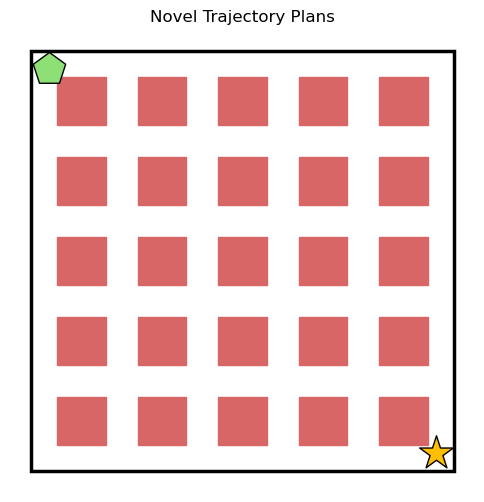

In [ ]:
# looking at trajectories and plans for novel ones generated zero shot
env = GridLand(n_size=n_size,timeout = 500)
env.reset()
fig, ax = env.get_mpl_plot()
ax.set_title('Novel Trajectory Plans')

novel_trajectories = filtered_trajectories-training_trajectory_visitations
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                if i < 250:
                        visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                        visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                        if visited_intersections_idx in novel_trajectories:
                                ax.scatter(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),s=5,label='Plan' + str(i),zorder=10-i)
                                color_index += 1/5
                        

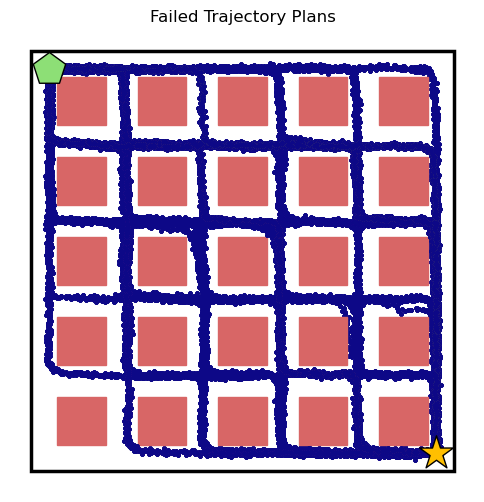

In [ ]:
# looking at failures
env = GridLand(n_size=n_size,timeout = 500)
env.reset()
fig, ax = env.get_mpl_plot()
ax.set_title('Failed Trajectory Plans')

failure_trajectories = generated_trajectory_visitations - filtered_trajectories
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #if i < 18 and i > 12:
                if i < 200:                       
                #print(trajectory.shape)
                        visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                        visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                        if visited_intersections_idx in failure_trajectories:
                                ax.scatter(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),s=5,label='Plan' + str(i),zorder=10-i)
                                color_index += 1/5

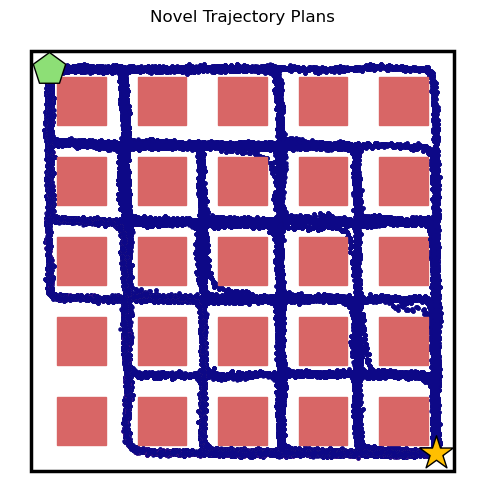

In [ ]:
# looking at trajectories and plans for novel ones generated zero shot
env = GridLand(n_size=n_size,timeout = 500)
env.reset()
fig, ax = env.get_mpl_plot()
ax.set_title('Novel Trajectory Plans')
novel_trajectories = filtered_trajectories-training_trajectory_visitations
color_index = 0
for ep in trajectories:
        for i,trajectory in enumerate(ep):
                #print(trajectory.shape)
                visited_intersections, visited_intersections_idx = find_trajectory_keypoints(trajectory,env)
                visited_intersections_idx = get_trajectory_sets([visited_intersections_idx]).pop()
                if visited_intersections_idx in novel_trajectories:
                        ax.scatter(replans[i,0,:,0],replans[i,0,:,1],color=colormaps['plasma_r'](color_index),s=5,label='Plan' + str(i),zorder=10-i)
                        color_index += 0.2
                        

In [ ]:
# way to look at individual training trajectories
import time
trajectory = batch['observations'][index]
env = GridLand(n_size=n_size,timeout = 500)
env.reset()
fig, ax = env.get_mpl_plot()
ax.scatter(trajectory[:,0],trajectory[:,1],color='r',s=5,zorder=10-i)
index+=1

NameError: name 'index' is not defined

IndexError: index 1 is out of bounds for axis 0 with size 1

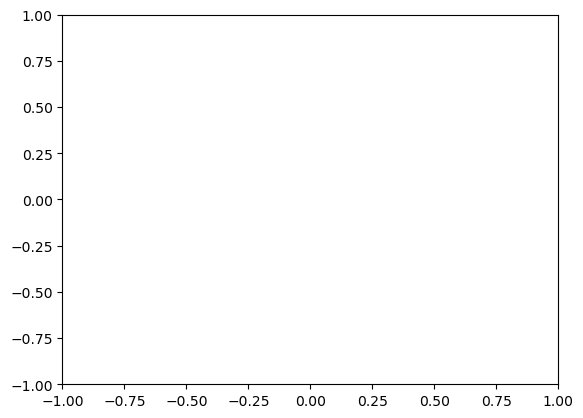

In [ ]:
plt.xlim((-1,1))
plt.ylim((-1,1))
replan_colors = colormaps['plasma_r']
gradient = np.linspace(0, 1, len(replans[0]))
index = 1
plt.scatter(replans[0][index,:,0],replans[0][index,:,1],c=range(len(replans[0][index,:,1])),s=5,label='Plan' + str(i),zorder=10-i)
print(replans[0][index,:,:])